In [1]:
# edit the code path accordingly
# see cli_demo.py if notebooks aren't your thing
code_root = '/data0/shubhtuls/code/factored3d'
import sys
import numpy as np
import os.path as osp
import scipy.misc
import scipy.io as sio
import torch
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append(osp.join(code_root, '..'))

In [2]:
import gflags as flags
from factored3d.demo import demo_utils

flags.FLAGS('')
opts = flags.FLAGS

# do not change the options below
opts.batch_size = 1
opts.num_train_epoch = 1
opts.name = 'dwr_shape_ft'
opts.classify_rot = True
opts.pred_voxels = True
opts.use_context = True

if opts.classify_rot:
    opts.nz_rot = 24
else:
    opts.nz_rot = 4

In [3]:
## Load the trained models
tester = demo_utils.DemoTester(opts)
tester.init_testing()

renderer = demo_utils.DemoRenderer(opts)

In [4]:
## Load input data
dataset = 'suncg'

img = scipy.misc.imread('./data/{}_img.png'.format(dataset))

img_fine = scipy.misc.imresize(img, (opts.img_height_fine, opts.img_width_fine))
img_fine = np.transpose(img_fine, (2,0,1))

img_coarse = scipy.misc.imresize(img, (opts.img_height, opts.img_width))
img_coarse = np.transpose(img_coarse, (2,0,1))

proposals = sio.loadmat('./data/{}_proposals.mat'.format(dataset))['proposals'][:, 0:4]

inputs = {}
inputs['img'] = torch.from_numpy(img_coarse/255.0).unsqueeze(0)
inputs['img_fine'] = torch.from_numpy(img_fine/255.0).unsqueeze(0)
inputs['bboxes_test_proposals'] = [torch.from_numpy(proposals)]

In [5]:
## Predict various representations
tester.set_input(inputs)
objects, layout = tester.predict_factored3d()
scene_voxels  = tester.predict_scene_voxels()
dmap = tester.predict_depth()

In [6]:
## Render the predictions
img_factored_cam, img_factored_novel = renderer.render_factored3d(objects, layout)
img_voxels_cam, img_voxels_novel = renderer.render_scene_vox(scene_voxels)
img_dmap_cam, img_dmap_novel = renderer.render_depth(dmap)


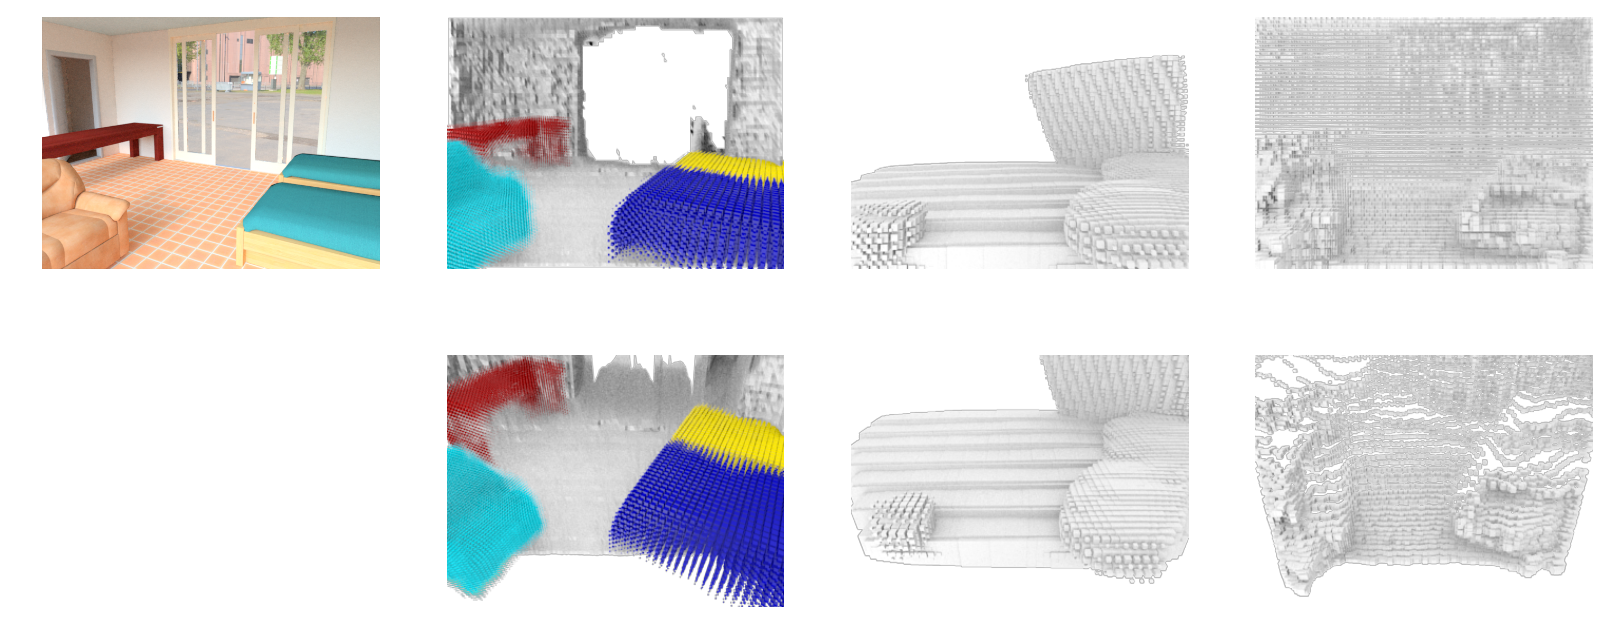

In [7]:
## Visualize predictions
f, axarr = plt.subplots(2, 4, figsize=(20, 8))

axarr[0, 0].imshow(img)
axarr[0, 0].axis('off')
axarr[1, 0].imshow(img*0 + 255)
axarr[1, 0].axis('off')

axarr[0, 1].imshow(img_factored_cam)
axarr[0, 1].axis('off')
axarr[1, 1].imshow(img_factored_novel)
axarr[1, 1].axis('off')

axarr[0, 2].imshow(img_voxels_cam)
axarr[0, 2].axis('off')
axarr[1, 2].imshow(img_voxels_novel)
axarr[1, 2].axis('off')

axarr[0, 3].imshow(img_dmap_cam)
axarr[0, 3].axis('off')
axarr[1, 3].imshow(img_dmap_novel)
axarr[1, 3].axis('off')

plt.show()